In [30]:
import pandas as pd

data = pd.read_csv('C:/Users/javi2/Documents/CD_aplicada/COBI/etl/data/Arribos2017-2021.csv')

# group by especie and unidad_economica
data = data[data['unidad_economica'].str.contains('LITORAL DE BAJA CALIFORNIA S DE PR DE RL')]
data = data.groupby(['especie', 'unidad_economica']).count().sort_values(by=['peso_desembarcado'], ascending=False)[['peso_desembarcado']]
data

,,peso_desembarcado
especie,unidad_economica,
LANGOSTA ROJA ENT. FCA.,LITORAL DE BAJA CALIFORNIA S DE PR DE RL,4982
CANGREJO MANOS DE FCO.,LITORAL DE BAJA CALIFORNIA S DE PR DE RL,120
ABULON AZUL ENT. FCO.,LITORAL DE BAJA CALIFORNIA S DE PR DE RL,78
ABULON NEGRO ENT. FCO.,LITORAL DE BAJA CALIFORNIA S DE PR DE RL,62
ROCOTE ENT. FCO.,LITORAL DE BAJA CALIFORNIA S DE PR DE RL,51
ABULON ROJO ENT. FCO.,LITORAL DE BAJA CALIFORNIA S DE PR DE RL,42
LENGUADO ENT. FCO.,LITORAL DE BAJA CALIFORNIA S DE PR DE RL,40
CANGREJO ENT. FCO.,LITORAL DE BAJA CALIFORNIA S DE PR DE RL,38
MOJARRA ENT. FCA.,LITORAL DE BAJA CALIFORNIA S DE PR DE RL,29


# Baseline

## Statsmodel

### Data Preprocessing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Load your dataset
data = pd.read_csv('/workspaces/COBI/Arribos2017-2021.csv')
# Filter by 'especie' and 'unidad_economica'
filtered_data = data[(data['especie'].str.contains('LANGOSTA')) & (data['unidad_economica'] == 'LITORAL DE BAJA CALIFORNIA S DE PR DE RL')]
# Adapt to ARIMA model
arima_data = filtered_data[['periodo_fin', 'peso_desembarcado']]
# Rename columns to Date and Y
arima_data.columns = ['Date', 'Y']
# Order by Date
arima_data.sort_values(by=['Date'], inplace=True)
# We take the sum of the values for each date
arima_data.groupby('Date').sum()

pd.to_datetime(arima_data['Date'])
arima_data.set_index('Date', inplace=True)

# Perform any necessary data transformations here, if needed
# For example, you can take the log of 'Y' if the data is not stationary
# data['Y'] = np.log(data['Y'])

# Split the data into training and testing sets (SLICED at 2021-01-01)
# the Date column is datetime
train = arima_data[arima_data.index <= '2021-01-01']
test = arima_data[arima_data.index >= '2021-01-01']

RMSE: 104.92819965393375


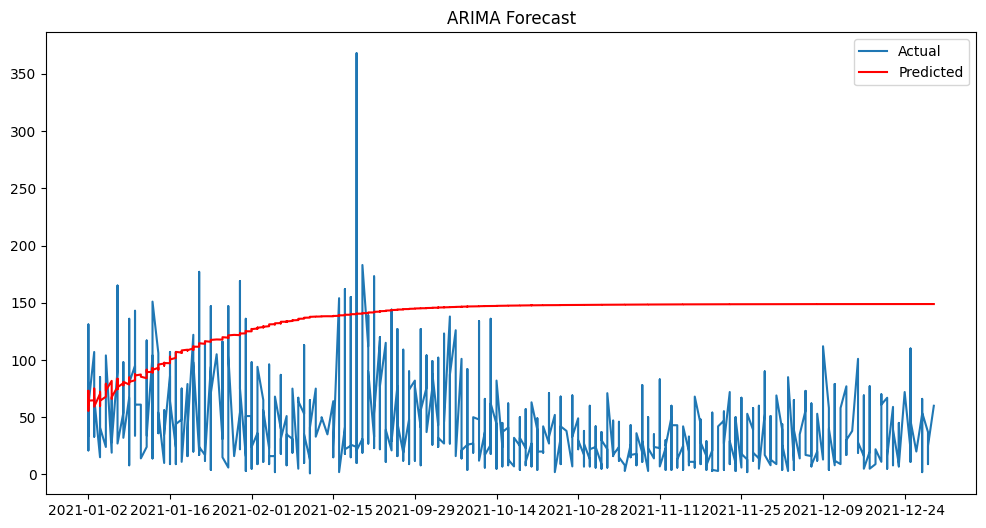

### Finding best ARIMA model

In [5]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from mango import scheduler, Tuner

def arima_objective_function(args_list):
    global data_values
    
    params_evaluated = []
    results = []
    
    for params in args_list:
        try:
            p,d,q = params['p'],params['d'], params['q']
            trend = params['trend']
            
            model = ARIMA(data_values, order=(p,d,q), trend = trend)
            predictions = model.fit()
            mse = mean_squared_error(data_values, predictions.fittedvalues)   
            params_evaluated.append(params)
            results.append(mse)
        except:
            #print(f"Exception raised for {params}")
            #pass 
            params_evaluated.append(params)
            results.append(1e5)
        
        #print(params_evaluated, mse)
    return params_evaluated, results

param_space = dict(p= range(0, 30),
                   d= range(0, 30),
                   q =range(0, 30),
                   trend = ['n', 'c', 't', 'ct']
                  )

conf_Dict = dict()
conf_Dict['num_iteration'] = 300
data_values = list(arima_data[arima_data.index <= '2021-01-01']['Y'])
tuner = Tuner(param_space, arima_objective_function, conf_Dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

Best score: 19144.920203886835: 100%|██████████| 300/300 [3:07:15<00:00, 37.45s/it]   

best parameters: {'d': 0, 'p': 29, 'q': 24, 'trend': 'c'}
best loss: 19144.920203886835


{'d': 0, 'p': 29, 'q': 24, 'trend': 'c'}
final model: (29, 0, 24) c
MSE error is: 19144.920203886835


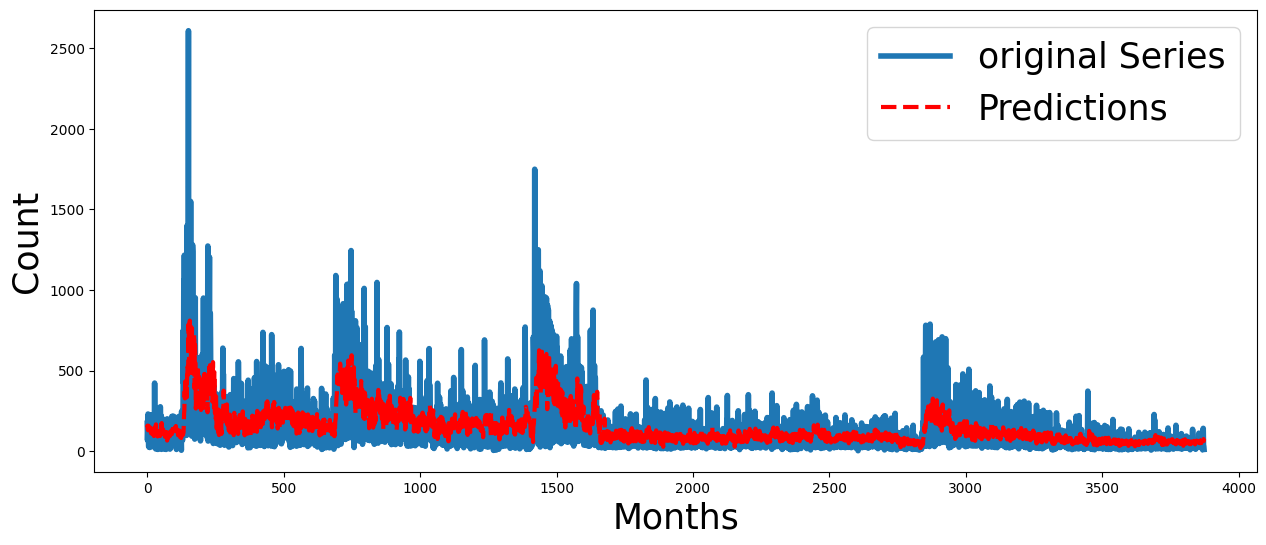

In [6]:

def plot_arima(data_values, order = (1,1,1), trend = 'c'):
    print('final model:', order, trend)
    model = ARIMA(data_values, order=order, trend = trend)
    results = model.fit()
    
    error = mean_squared_error(data_values, results.fittedvalues)   
    print('MSE error is:', error)
    
    from matplotlib import pyplot as plt
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(6)
    plt.plot(data_values, label = "original Series", linewidth = 4)
    plt.plot(results.fittedvalues, color='red', label = "Predictions", linestyle='dashed', linewidth = 3)
    plt.legend(fontsize = 25)
    plt.xlabel('Months', fontsize = 25)
    plt.ylabel('Count', fontsize = 25)
    plt.show()

print(results['best_params'])

order = (results['best_params']['p'], results['best_params']['d'], results['best_params']['q'])
plot_arima(data_values, order=order, trend = results['best_params']['trend'])


### Prediction

In [13]:
# Fit an ARIMA model
model = ARIMA(train, order=order)
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))

# Calculate RMSE (Root Mean Squared Error) to evaluate the model
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse}')

# Plot the original data and predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Y'], label='Actual')
# Only show every two weeks in the x-axis
plt.xticks(np.arange(0, len(test), 14))
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()



ValueError: Found input variables with inconsistent numbers of samples: [1124, 300]